<a href="https://colab.research.google.com/github/C-W-Z/deep-learning/blob/master/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [163]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
print(torch.__version__)

print(torch.cuda.is_available())
print(torch.cuda.device_count())
# print(torch.cuda.current_device())
# print(torch.cuda.device(0))
# print(torch.cuda.get_device_name(0))

# get device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Check GPU details with nvidia-smi
!nvidia-smi

2.3.1+cu121
False
0
cpu
/bin/bash: line 1: nvidia-smi: command not found


In [166]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [167]:
print(X_train.shape, y_train.shape, X_test.shape, y_train.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (60000,)


In [164]:
import matplotlib.pyplot as plt

def plot_img(img):
    img = np.array(img)
    img.shape = (28,28)
    plt.imshow(img, cmap='gray')
    plt.show()

2


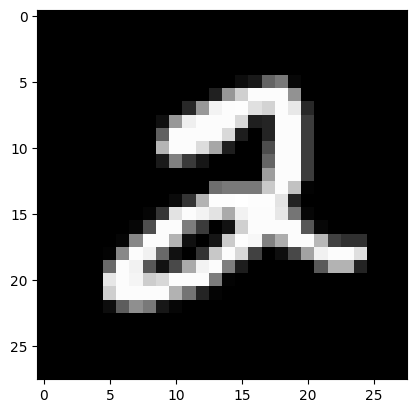

In [ ]:
print(y_train[5])
plot_img(X_train[5])

# Preprocessing

In [ ]:
# Reshape (?, 28, 28) to (?, 784)
# X_train = X_train.reshape(X_train.shape[0], -1)
# X_test = X_test.reshape(X_test.shape[0], -1)

In [ ]:
print(X_train.shape, X_test.shape)

In [168]:
# Normalize
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [ ]:
print(X_train.mean(), X_train.std())
print(X_test.mean(), X_test.std())

0.13066062 0.30810776
0.13251467 0.31048027


In [169]:
# one hot encoding for 10 classes
y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

In [170]:
print(y_train.shape, y_test.shape)

(60000, 10) (10000, 10)


In [171]:
# convert data to tensor
X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train)
X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test)

In [172]:
print(type(X_train))

<class 'torch.Tensor'>


In [173]:
# put data to Device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

In [174]:
print(X_train.device)

cpu


In [175]:
EPOCH = 2
BATCH_SIZE = 32
LEARNING_RATE = 0.001

In [176]:
# construct data loader
dataset_train = TensorDataset(X_train, y_train)
dataset_test = TensorDataset(X_test, y_test)
loader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

# Model

In [192]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),  # (1, 28, 28) -> (16, 28, 28)
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                               # (16, 28, 28) -> (16, 14, 14)
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), # (16, 14, 14) -> (32, 14, 14)
        # nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0)                                # (32, 14, 14) -> (32, 7, 7)
    )
    self.fc = nn.Sequential(
        nn.Linear(32 * 7 * 7, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )

  def forward(self, x):
    x = self.conv(x)
    x = x.view(-1, 32 * 7 * 7)
    return self.fc(x)

In [193]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [194]:
from torchsummary import summary

print(model)
summary(model, (1, 28, 28)) # (channel, height, width)

CNN(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=1568, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
       BatchNorm2d-3           [-1, 16, 28, 28]              32
         MaxPool2d-4           [-1, 16, 14, 

# Train & Test

In [195]:
# prompt: Train the model with loader_train & save it, afterward, load the model and train again

def train_model(model, loader_train, optimizer, criterion, EPOCH):
  # Train the model with loader_train
  model.train()
  for epoch in range(EPOCH):
    for batch_idx, (X, y) in enumerate(loader_train):
      # reshape mini-batch data to (batch_size, 1, 28, 28)
      X = X.view(-1, 1, 28, 28)
      # set gradients to zero
      optimizer.zero_grad()
      # forward pass
      output = model(X)
      # calculate loss
      loss = criterion(output, y)
      # backward pass
      loss.backward()
      # update parameters
      optimizer.step()

      batch_idx += 1
      if batch_idx % (len(loader_train) / 10) == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(X), len(loader_train.dataset),
          100. * batch_idx / len(loader_train), loss.item()))

  # Save the model
  torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
  }, 'mnist_cnn.pth')

In [196]:
train_model(model, loader_train, optimizer, criterion, EPOCH)

Train Epoch: 0 [12000/60000 (20%)]	Loss: 0.040331
Train Epoch: 0 [24000/60000 (40%)]	Loss: 0.006736
Train Epoch: 0 [36000/60000 (60%)]	Loss: 0.027358
Train Epoch: 0 [48000/60000 (80%)]	Loss: 0.081097
Train Epoch: 0 [60000/60000 (100%)]	Loss: 0.014119
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.007318
Train Epoch: 1 [24000/60000 (40%)]	Loss: 0.002987
Train Epoch: 1 [36000/60000 (60%)]	Loss: 0.003115
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.046102
Train Epoch: 1 [60000/60000 (100%)]	Loss: 0.006849


In [198]:
# Load the model
mnist_cnn = torch.load('mnist_cnn.pth')
model = CNN().to(device)
model.load_state_dict(mnist_cnn['model_state_dict'])
optimizer.load_state_dict(mnist_cnn['optimizer_state_dict'])

# Train the model again
train_model(model, loader_train, optimizer, criterion, EPOCH)

Train Epoch: 0 [12000/60000 (20%)]	Loss: 0.053540
Train Epoch: 0 [24000/60000 (40%)]	Loss: 0.003245
Train Epoch: 0 [36000/60000 (60%)]	Loss: 0.024647
Train Epoch: 0 [48000/60000 (80%)]	Loss: 0.023323
Train Epoch: 0 [60000/60000 (100%)]	Loss: 0.022234
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.017467
Train Epoch: 1 [24000/60000 (40%)]	Loss: 0.004459
Train Epoch: 1 [36000/60000 (60%)]	Loss: 0.043940
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.010792
Train Epoch: 1 [60000/60000 (100%)]	Loss: 0.046247


In [199]:
# prompt: Test the model with loader_test or X_test & y_test

# Test
correct = 0
total = 0
model.eval()
with torch.no_grad():
  for X, y in loader_test:
    X = X.view(-1, 1, 28, 28)
    output = model(X)
    _, predicted = torch.max(output.data, 1)
    _, true_label = torch.max(y.data, 1)
    total += y.size(0)
    correct += (predicted == true_label).sum().item()

print('Accuracy of the network on the', total, 'test images:', correct, '/', total, '=', (100 * correct / total), '%')


Accuracy of the network on the 10000 test images: 9865 / 10000 = 98.65 %


# Test

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test.png to test.png


(28, 28)


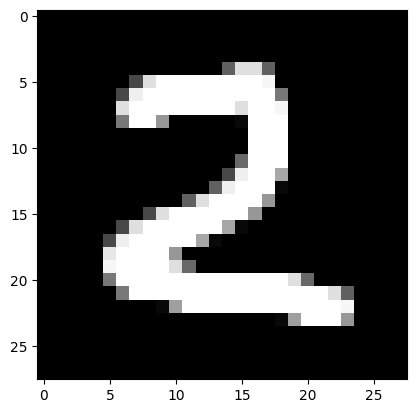

In [200]:
import cv2

img = cv2.imread('test.png', cv2.IMREAD_GRAYSCALE)
img = 255 - img
print(img.shape)
plot_img(img)

In [201]:
# prompt: Write a function to predict a 28*28 image

def predict_img(img):
  # Preprocessing
  img = cv2.resize(img, (28, 28))
  img = img.astype('float32') / 255
  img = torch.tensor(img)
  img = img.view(-1, 1, 28, 28)
  img = img.to(device)
  # Predict
  with torch.no_grad():
    output = model(img)
    _, predicted = torch.max(output.data, 1)
    return predicted.item()


In [202]:
predict_img(img)

2